In [20]:
#!pip install fastai --upgrade
#!pip install fastai2_extensions

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from fastai.vision.all import *
import PIL
from fastai2_extensions.interpret.all import *
from sklearn.metrics import accuracy_score
from glob import glob

# Look at the data

In [4]:
STUDY_DIRECTORY =  Path('gdrive/My Drive/MURA_sample') 

In [5]:
df = pd.read_csv(STUDY_DIRECTORY/'data.csv')

In [6]:
df.head()

,img_path,subject_id,study_id,label,is_valid
0,gdrive/My Drive/MURA_sample/train/XR_HAND/patient00008/study1_positive/image1.png,8,00008_study1,positive,False
1,gdrive/My Drive/MURA_sample/train/XR_HAND/patient00008/study1_positive/image2.png,8,00008_study1,positive,False
2,gdrive/My Drive/MURA_sample/train/XR_HAND/patient00008/study1_positive/image3.png,8,00008_study1,positive,False
3,gdrive/My Drive/MURA_sample/train/XR_HAND/patient00050/study1_negative/image1.png,50,00050_study1,negative,False
4,gdrive/My Drive/MURA_sample/train/XR_HAND/patient00050/study1_negative/image2.png,50,00050_study1,negative,False


In [7]:
df_studies = df.drop_duplicates(subset = ["study_id"])

#### Number of unique subjects 


In [8]:
df_studies.subject_id.nunique()

2104

#### Number of unique studies (some patients can have several studies)

In [9]:
df_studies.study_id.nunique()

2185

#### Example of a study data

![study](https://github.com/skaliy/rad230_dl/blob/main/patient00008.png?raw=1)


#### Medical datasets are often imbalanced

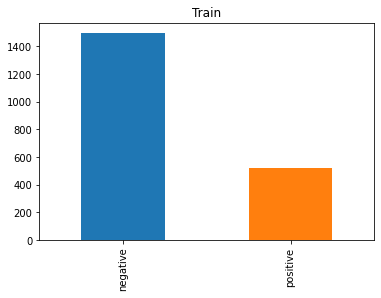

In [10]:
df_studies.loc[~df_studies.is_valid].label.value_counts().plot(kind='bar', color=['C0', 'C1'], title='Train');

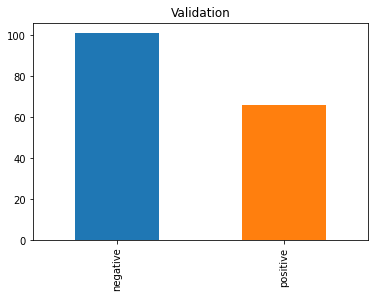

In [11]:
df_studies.loc[df_studies.is_valid].label.value_counts().plot(kind='bar', color=['C0', 'C1'], title='Validation');

In [12]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                   get_x=ColReader('img_path'), 
                   get_y=ColReader('label'),
                   splitter=ColSplitter(col='is_valid'), 
                   item_tfms=Resize(512), 
                   batch_tfms=aug_transforms(size=256))

In [13]:
#### batch size is the number of samples that will be passed through to the network at one time during training

In [14]:
batch_size=16

In [15]:
dls = dblock.dataloaders(df, bs=batch_size)

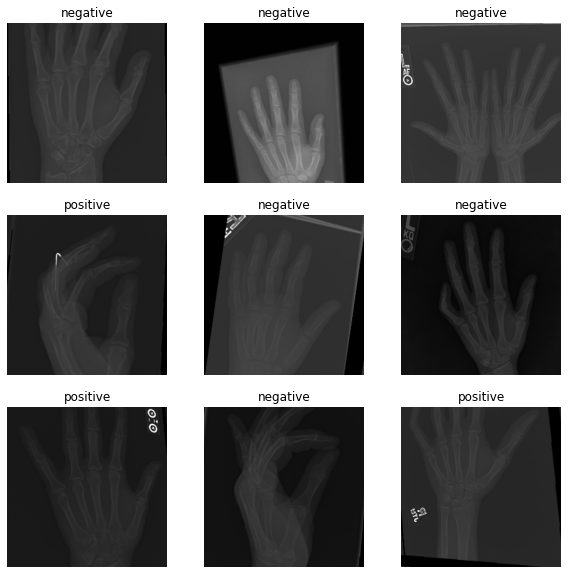

In [16]:
dls.show_batch(figsize=(10, 10))

### Training process

In [17]:
learn = vision_learner(dls, resnet50, metrics=accuracy, model_dir='')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [18]:
# learn.lr_find()

In [ ]:
learn.fine_tune(2, 1e-3)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.save('model-1');

# Intepretation

In [ ]:
learn.load(STUDY_DIRECTORY/'model-1');

In [ ]:
preds,targs = learn.get_preds(ds_idx=1)
preds = np.argmax(preds, axis=1)

In [ ]:
print('Accuracy:',round(accuracy_score(preds, targs),3))

Accuracy: 0.798


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

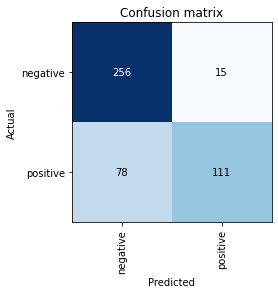

In [ ]:
interp.plot_confusion_matrix()

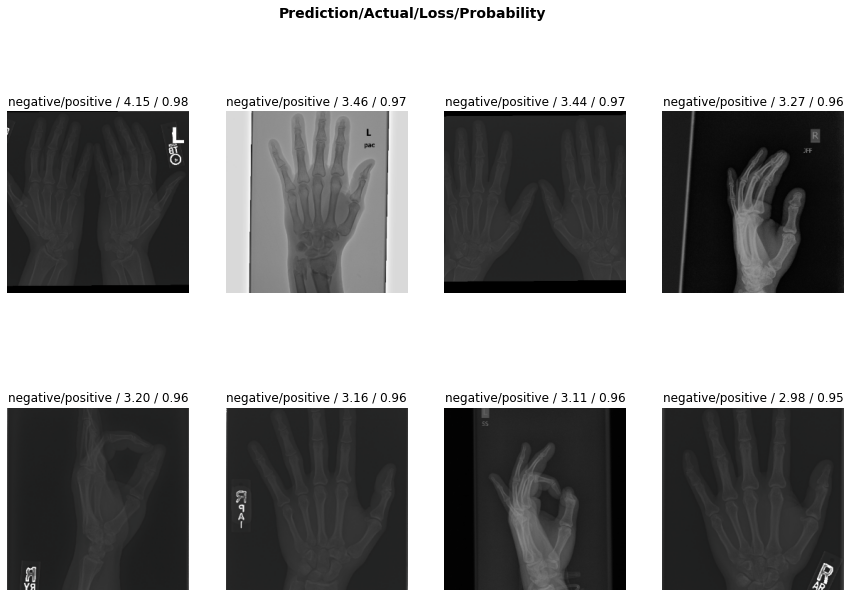

In [ ]:
interp.plot_top_losses(8, figsize=(15,10))

In [ ]:
interp = ClassificationInterpretationEx.from_learner(learn)

In [ ]:
df_positive_validation = df.loc[(df.is_valid) & (df.label=='positive')].reset_index(drop=True)
df_positive_validation.head()

,img_path,subject_id,study_id,label,is_valid
0,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11194/study1_positive/image1.png,11194,11194_study1,positive,True
1,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11194/study1_positive/image2.png,11194,11194_study1,positive,True
2,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11194/study1_positive/image3.png,11194,11194_study1,positive,True
3,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11216/study1_positive/image1.png,11216,11216_study1,positive,True
4,gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11216/study1_positive/image2.png,11216,11216_study1,positive,True


In [ ]:
idx = 0
fname = df_positive_validation.img_path.tolist()[idx]
fname

'gdrive/My Drive/MURA_sample/valid/XR_HAND/patient11194/study1_positive/image1.png'

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


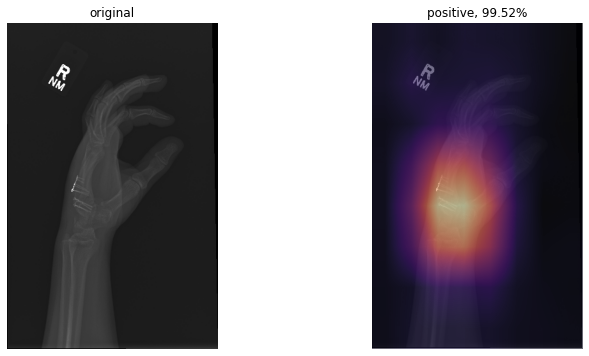

In [ ]:
gcam = GradCam(learn, fname, None)
gcam.plot(full_size=True, plot_original=True, figsize=(12,6))